# Messy Analysis

In [1]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.summarization import keywords, summarize
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import utils
import csv
import multiprocessing
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from gensim.models.phrases import Phrases
from gensim.models.phrases import Phraser

product_info = pd.read_csv('../data/CatfoodProductInfo.csv')
reviews = pd.read_csv('../data/CatfoodReviewsInfo.csv')
df = reviews.join(product_info.set_index('product'), on='product',how='left')
df = df.dropna(axis=0,how='any')

ninit = len(set(df['product']))
print(f'Prior to filtering out products with less than 50 reviews, there are {ninit} products')

filter = df.groupby('product')['rating'].count() >= 50
df = df[filter[df['product']].values]

nfin = len(set(df['product']))
print(f'After filtering out products with less than 50 reviews, there are {nfin} products')

prod_info_filter = [product in set(df['product']) for product in product_info['product']]
product_info = product_info[prod_info_filter]

Prior to filtering out products with less than 50 reviews, there are 675 products
After filtering out products with less than 50 reviews, there are 453 products


In [2]:
brandnames = set(df['brand'].unique())
print(f'There are {len(brandnames)} brands represented across our reviews.')

nprods = len(df.groupby('product'))
nrevs = len(df)
print(f'There are {nrevs} reviews across {nprods} products')
# brandnames

There are 50 brands represented across our reviews.
There are 36345 reviews across 453 products


In [3]:
print(f'Before removing straggler variety packs: {len(df)}')
exclude_words = ['Variety',]
for word in exclude_words:
    df = df[~df['product'].str.contains(word)]
    product_info = product_info[~product_info['product'].str.contains(word)]
    
print(f'After removing straggler variety packs: {len(df)}')

# word = 'Variety'
# df[~df['product'].str.contains(word)]

Before removing straggler variety packs: 36345
After removing straggler variety packs: 36009


### following https://towardsdatascience.com/implementing-multi-class-text-classification-with-doc2vec-df7c3812824d 
and(?)
https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4

In [4]:
# standardize text
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    for brandname in brandnames:
        df[text_field] = df[text_field].str.replace(brandname.lower(),"")

        
    return df

# Function for tokenizing
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens


# Label encode the names
le = preprocessing.LabelEncoder()
df['product_label']=le.fit_transform(df['product'])

# print(train_documents[0])

df_clean = standardize_text(df,'review_text')

In [5]:
from nltk.tokenize import RegexpTokenizer
pd.set_option('display.width',200)

tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
df_clean["tokens"] = df_clean["review_text"].apply(tokenizer.tokenize)

df_clean['tokens'] = df_clean['tokens'].apply(lambda x: ' '.join( [item for item in x if item not in stop_words]))
# df_clean['tokens'] = df_clean['tokens'].apply(lambda x: [item for item in x if item not in stop_words])


all_tokens = [t.split() for t in df_clean['tokens']]
phrases = Phrases(all_tokens)
bigram = Phraser(phrases)
trigram_phrases = Phrases(bigram[all_tokens])
trigram = Phraser(phrases)

df_clean['input'] = df_clean['tokens'].apply(lambda x: bigram[x.split(' ')])



# train, test = train_test_split(df[['review_text','product_label']],test_size=0.0)

data = df_clean.copy()
data['n_words'] = data['input'].apply(lambda r: len(r))
print(f'Number of reviews prior to dropping short ones {len(data)}')
df_clean = df_clean.loc[data['n_words']>=10]
data = data.loc[data['n_words']>=10]
print(f'Number of reviews after dropping short ones {len(data)}')
# data.head(5)

data.to_csv('prepared_data.csv')

data_tagged = data.apply(
    lambda r: TaggedDocument(words=r['input'], tags=[r.product_label]), axis=1)


Number of reviews prior to dropping short ones 36009
Number of reviews after dropping short ones 25974


In [6]:
# figure out how to properly load in the saved csv
import ast

data = pd.read_csv('prepared_data.csv')
data_tagged = data.apply(
    lambda r: TaggedDocument(words=ast.literal_eval(r['input']), tags=[r.product_label]), axis=1)

In [7]:
import multiprocessing
cores = multiprocessing.cpu_count()
data_tagged.sample(1).values

array([TaggedDocument(words=['one', 'cats', 'experiencing', 'bad', 'case', 'feline', 'acne', 'vet', 'thinks', 'allergy', 'chicken', 'process', 'attempting', 'eliminate', 'chicken', 'chicken', 'protein', 'products', 'cats', 'food', 'difficult', 'thing', 'given', 'common', 'ingredient', 'vast', 'majority', 'catfoods', 'biggest', 'concern', 'purchasing', 'new', 'catfood', 'cat', 'w', 'feline', 'acne', 'would', 'eat', 'second', 'concern', 'cat', 'would', 'like', 'lot', 'quite', 'overweight', 'need', 'extra', 'calories', 'far', 'good', 'cat', 'w', 'feline', 'acne', 'eat', 'new', 'wet', 'food', 'cat', 'care', '5_star', 'review', 'tentative', 'review', 'based'], tags=[402])],
      dtype=object)

In [8]:
cores = multiprocessing.cpu_count()

model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, 
                     workers=cores, alpha=0.025, min_alpha=0.001)
model_dm = Doc2Vec(dm=1, vector_size=300, window=10, negative=5, hs=0, min_count=2, sample=0,
                   workers=cores, alpha=0.025, min_alpha = 0.001)
model_dbow.build_vocab([x for x in tqdm(data_tagged.values)])
model_dm.build_vocab([x for x in tqdm(data_tagged.values)])

100%|██████████| 25974/25974 [00:00<00:00, 1097240.88it/s]


In [9]:
%%time
cores = multiprocessing.cpu_count()
train_data = utils.shuffle(data_tagged)

model_dbow.train(train_data, total_examples=len(train_data), epochs=30)
model_dm.train(train_data, total_examples=len(train_data), epochs=30)

CPU times: user 4min 56s, sys: 32.1 s, total: 5min 28s
Wall time: 2min 50s


In [11]:
label_decoder = df[['product_label','product']].set_index('product_label').to_dict()['product']
label_encoder = df[['product_label','product']].set_index('product').to_dict()['product_label']

num_returned = 5
results_shown = 10

pd.set_option('display.max_colwidth', 200)
positives = [67,2]
negatives = [228,361]
# positives = [2]
# negatives = []

similarity_results = pd.DataFrame(index = product_info['product'],columns = ['dbow_rank','dm_rank','combined'])
similar_items_dbow = model_dbow.docvecs.most_similar(positive=positives,negative = negatives,topn=num_returned)
similar_items_dm = model_dm.docvecs.most_similar(positive=positives,negative = negatives,topn=num_returned)

# print("DBOW:",similar_items_dbow)
# print("DM:",similar_items_dm)

decoded_dbow = [(label_decoder[label],similarity) for (label,similarity) in similar_items_dbow]
decoded_dm = [(label_decoder[label],similarity) for (label,similarity) in similar_items_dm]

print("Dbow model similarities:")
for (rank, product) in enumerate(decoded_dbow):
    name = product[0]
    score = product[1]
    similarity_results.loc[name,"dbow_rank"] = rank
    print(f'{rank}: {name}, {score}')

print("\n DM model similarities:")
for (rank, product) in enumerate(decoded_dm):
    name = product[0]
    score = product[1]
    similarity_results.loc[name,"dm_rank"] = rank
    print(f'{rank}: {name}, {score}')

similarity_results.fillna(value=num_returned+1,inplace=True)
similarity_results["combined"] = (similarity_results["dbow_rank"] + similarity_results["dm_rank"])/2

liked = [label_decoder[i] for i in positives]
disliked = [label_decoder[i] for i in negatives]
print(f'Cat liked: {liked}. Cat disliked: {disliked}')
print("\n Combined scores")
similarity_results.sort_values(by='combined',ascending=True).drop(columns=['dbow_rank','dm_rank'],axis=0).head(results_shown)




Dbow model similarities:
0: I and Love and You  Purrky Turkey Pate Grain-Free Canned Cat Food, 0.18912281095981598
1: American Journey Minced Turkey Recipe in Gravy Grain-Free Canned Cat Food, 0.18862849473953247
2: Tiki Cat Koolina Luau Chicken with Egg in Chicken Consomme Grain-Free Canned Cat Food, 0.18762631714344025
3: Purina Pro Plan Savor Adult Chicken  Tomato & Pasta Entree in Gravy Canned Cat Food, 0.14358943700790405
4: Purina Pro Plan True Nature Classic Natural Chicken & Liver Entree Grain-Free Canned Cat Food, 0.13761503994464874

 DM model similarities:
0: Triumph Ocean Fish Formula Canned Cat Food, 0.3999671936035156
1: Tiny Tiger Pate Turkey and Giblets Recipe Grain-Free Canned Cat Food, 0.3908323049545288
2: Tiny Tiger Pate Salmon Recipe Grain-Free Canned Cat Food, 0.3889143764972687
3: Tiny Tiger Pate Whitefish and Tuna Recipe Grain-Free Canned Cat Food, 0.3744421601295471
4: Dave’s Pet Food Naturally Healthy Grain-Free Turkey & Giblets Dinner Canned Cat Food, 0.37383

,combined
product,
I and Love and You Purrky Turkey Pate Grain-Free Canned Cat Food,3.0
Triumph Ocean Fish Formula Canned Cat Food,3.0
American Journey Minced Turkey Recipe in Gravy Grain-Free Canned Cat Food,3.5
Tiny Tiger Pate Turkey and Giblets Recipe Grain-Free Canned Cat Food,3.5
Tiki Cat Koolina Luau Chicken with Egg in Chicken Consomme Grain-Free Canned Cat Food,4.0
Tiny Tiger Pate Salmon Recipe Grain-Free Canned Cat Food,4.0
Tiny Tiger Pate Whitefish and Tuna Recipe Grain-Free Canned Cat Food,4.5
Purina Pro Plan Savor Adult Chicken Tomato & Pasta Entree in Gravy Canned Cat Food,4.5
Purina Pro Plan True Nature Classic Natural Chicken & Liver Entree Grain-Free Canned Cat Food,5.0


In [12]:
filter_products = [item in df['product'].values for item in product_info['product']]
af = product_info[filter_products]
af['product_label']=le.fit_transform(af['product'])
brand_list = {name : brand for (name,brand) in zip(af['product'],af['brand'])}

sample_brands = ['Fancy Feast',
                 'Friskies',
                 'Blue Buffalo',
                 'Purina Pro Plan', 
                 'Hills Prescription Diet',
                 'Nutro',
                 'Wellness',
                ]

In [13]:
vec_list = {name : model_dbow.docvecs[x] for (name,x) in zip(af['product'].to_list(),af['product_label'].to_list()) if brand_list[name] in sample_brands
           };

embeddings = pd.DataFrame.from_dict(vec_list,orient='index')

/Users/danielben-zion/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


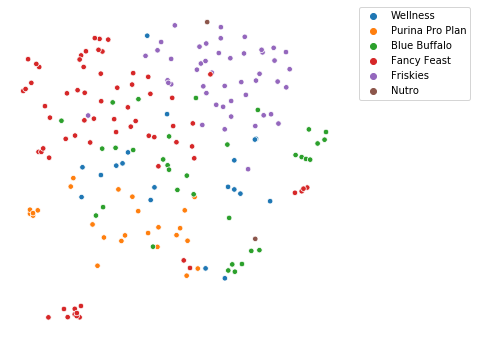

In [15]:
# from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import umap 

%matplotlib inline
# pca = PCA(n_components=2)
embeddings_viz = umap.UMAP(min_dist = 0.0,
                          n_neighbors = 20,
                          metric='euclidean').fit_transform(embeddings)
brand_name = [brand_list[name] for name in embeddings.index]

fig,axis = plt.subplots(figsize=(6,6))
sns.scatterplot(x=embeddings_viz[:,0], y=embeddings_viz[:,1],hue = brand_name, s = 30,ax=axis)
axis.axis('off')
axis.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# plt.savefig('plots/BrandSeparation.png',bbox_inches='tight')



In [25]:
import pickle
# save what we need to use in the backend

# the model
model_dbow.save('catfood-d2v-dbow.model')
model_dm.save('catfood-d2v-dm.model')

# the label decoder
with open("label-decoder.pkl","wb") as f:
    pickle.dump(label_decoder,f)
    
# the label encoder
with open("label-encoder.pkl","wb") as f:
    pickle.dump(label_encoder,f)

import json
name_list_to_json = []

for name in set(df_clean['product']):
    name_list_to_json.append(dict(name=name))

with open('foods.json','w') as json_file:
    json.dump(name_list_to_json,json_file)
    
model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [39]:
label=label_encoder['Tiny Tiger Chunks in EXTRA Gravy Tuna Recipe Grain-Free Canned Cat Food']
word = model_dbow.docvecs[label]
# print(word)
print(model_dbow.wv.similar_by_vector(word))

[('5_5', 0.22314494848251343), ('female', 0.22056111693382263), ('level', 0.20638930797576904), ('easiest', 0.20186680555343628), ('special', 0.1922738254070282), ('unexpected', 0.18582645058631897), ('2', 0.1849033534526825), ('extend', 0.18199223279953003), ('whilst', 0.18096841871738434), ('wont_touch', 0.17899560928344727)]


## Validation Exploration

In [26]:
import pickle
model_dbow = Doc2Vec.load('catfood-d2v-dbow.model')
model_dm = Doc2Vec.load('catfood-d2v-dm.model')
label_encoder = pickle.load( open('label-encoder.pkl','rb') )
label_decoder = pickle.load( open('label-decoder.pkl','rb') )
pd.set_option('display.max_colwidth',200)

In [16]:
author_count = df.groupby('review_author')['review_author'].count()
authorgroup = author_count[(author_count > 5) & (author_count < 15)]
authorgroup.sample(5)
# authorgroup = author_count

review_author
Birti            6
Kris            14
CatWhisperer     9
carol334         6
Jojo            13
Name: review_author, dtype: int64

In [22]:
user = 'CarolinaCat'
df[df['review_author']==user][['product','rating','review_text','product_label']]

,product,rating,review_text,product_label
808,I and Love and You Oh My Cod! Pate Grain-Free Canned Cat Food,5,i always feed my cats a variety of canned foods in the evening and this flavor got a lot of attention when i first opened it i hope they stay enthusiastic about it it's always nice to find a hea...,242
1418,Tiki Cat Tahitian Grill Sardine Cutlets Grain-Free Canned Cat Food,4,"when i find food still in the bowl when i get up in the morning, it tells me my cats don't particularly like something this was the case with this food",398
10250,Weruva Cats in the Kitchen Lamb Burgini Lamb Au Jus Grain-Free Canned Cat Food,3,my cats seemed to like glam and punk pretty well but this variety has been a dud with them i really like the brand but not this flavor,434
12791,Blue Buffalo Healthy Gourmet Flaked Fish & Shrimp Entree in Gravy Canned Cat Food,5,i wasn't sure if my cats would eat this or not since they often don't like foods that have lumps but they are enthusiastic about it definitely a keeper with my 7 kitties,30
15584,Wellness Complete Health Chicken & Lobster Formula Canned Cat Food,5,this flavor has been a big hit with all of my gang i will definitely make it part of my regular chewy orders in the future,420
24598,Purina Beyond Grain-Free Trout & Catfish Pate Recipe Canned Cat Food,5,all my cats really seem to like this which is saying a lot i have one that has verged into a picky eater but this is on her aok list,302
28486,Fancy Feast Classic Tender Beef & Liver Feast Canned Cat Food,2,i have 7 cats and none of them liked this food they simply do not like beef flavored cat foods,88
33834,Blue Buffalo Basics Limited Ingredient Grain-Free Indoor Fish & Potato Entree Adult Canned Cat Food,4,this has probably been one of the poorest selections of cat food that my cats have been given they eventually eat all of it but it is usually the last to go i probably won't reorder,23
34140,Weruva Nine Liver with Chicken & Chicken Liver in Gravy Grain-Free Canned Cat Food,3,my cats have little enthusiasm for this flavor makes great cat food but this variety is not a winner with my crew,441
40039,Tiki Cat Makaha Grill Mackerel & Sardine in Calamari Consomme Grain-Free Canned Cat Food,4,my cats seem to like an awful lot of other foods over this,393


In [23]:
positives = [242,30]
negatives = [441,88]

In [24]:
num_returned = 1000
results_shown = 10

similarity_results = pd.DataFrame(index = product_info['product'],columns = ['dbow_rank','dm_rank','combined'])
similar_items_dbow = model_dbow.docvecs.most_similar(positive=positives,negative = negatives,topn=num_returned)
similar_items_dm = model_dm.docvecs.most_similar(positive=positives,negative = negatives,topn=num_returned)
#     print(similar_items)
decoded_dbow = [(label_decoder[label],similarity) for (label,similarity) in similar_items_dbow]
decoded_dm = [(label_decoder[label],similarity) for (label,similarity) in similar_items_dm]

def scale_scores(df,field):
    df[field] = df[field].apply(lambda r: r/df[field].max())
    return df

dbow_results = pd.DataFrame(decoded_dbow,columns=['product','sim_score'])
dbow_results = scale_scores(dbow_results,'sim_score')

dm_results = pd.DataFrame(decoded_dm,columns=['product','sim_score'])
dm_results = scale_scores(dm_results,'sim_score')

combined_results = dbow_results.set_index('product').join(dm_results.set_index('product'), how = 'left', 
                                    lsuffix = '_db', rsuffix = '_dm')


combined_results['avg_sim'] = (combined_results['sim_score_db'] + combined_results['sim_score_dm'])/2
combined_results.sort_values(by='avg_sim',ascending=False).head()
    
    
# print("Dbow model similarities:")
# for (rank, product) in enumerate(decoded_dbow):
#     name = product[0]
#     score = product[1]
#     similarity_results.loc[name,"dbow_rank"] = rank
#     print(f'{rank}: {name}, {score}')

# print("\n DM model similarities:")
# for (rank, product) in enumerate(decoded_dm):
#     name = product[0]
#     score = product[1]
#     similarity_results.loc[name,"dm_rank"] = rank
#     print(f'{rank}: {name}, {score}')

# similarity_results.fillna(value=num_returned+1,inplace=True)
# similarity_results["combined"] = (similarity_results["dbow_rank"] + similarity_results["dm_rank"])/2

# liked = [label_decoder[i] for i in positives]
# disliked = [label_decoder[i] for i in negatives]
# print(f'Cat liked: {liked}. Cat disliked: {disliked}')
# print("\n Combined scores")
# output = similarity_results.sort_values(by='combined',ascending=True).drop(columns=['dbow_rank','dm_rank'],axis=0).head(results_shown)
# output

,sim_score_db,sim_score_dm,avg_sim
product,,,
Blue Buffalo Healthy Gourmet Pate Ocean Fish & Tuna Entree Adult Canned Cat Food,1.000000,0.837912,0.918956
Hill’s Science Diet Adult Sensitive Stomach & Skin Chicken & Vegetable Entrée Canned Cat Food,0.729635,0.887150,0.808392
Blue Buffalo Wilderness Wild Delights Flaked Chicken & Trout in Tasty Gravy for Kittens Grain-Free Canned Cat Food,0.676285,0.888736,0.782510
Blue Buffalo Healthy Gourmet Pate Salmon Entree Indoor Adult Canned Cat Food,0.900538,0.595322,0.747930
Blue Buffalo Freedom Indoor Adult Chicken Recipe Grain-Free Canned Cat Food,0.713992,0.760642,0.737317


In [25]:
test = df[df['review_author']==user][['product','rating']].set_index('product')

In [26]:
val = test.join(combined_results,how='left')

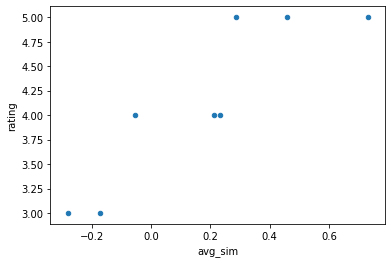

In [27]:
val.plot.scatter(x='avg_sim',y='rating')

In [28]:
import numpy as np
def scale_scores(df,field):
    scaleby = max(np.abs(df[field].min()),np.abs(df[field].max()))
    df[field] = df[field]/scaleby
    return df

def generate_val_data(user):
    num_returned = 1000
    userdata = df[df['review_author']==user]
    
    if len(userdata.groupby('rating').count()) == 1:
        return
    
    

    
    low_rankings = userdata[userdata['rating'] <= 3].sort_values(by='rating',ascending=True)
    high_rankings = userdata[userdata['rating'] >= 4].sort_values(by='rating',ascending=False)
    
    
#     if len(low_rankings) < 3:
#         return
    
    
    negatives = [val for val in low_rankings.head(2)['product_label']]
    positives = [val for val in high_rankings.head(2)['product_label']]
    
    similar_items_dbow = model_dbow.docvecs.most_similar(positive=positives,negative = negatives,topn=num_returned)
    similar_items_dm = model_dm.docvecs.most_similar(positive=positives,negative = negatives,topn=num_returned)

    decoded_dbow = [(label_decoder[label],similarity) for (label,similarity) in similar_items_dbow]
    decoded_dm = [(label_decoder[label],similarity) for (label,similarity) in similar_items_dm]

    dbow_results = pd.DataFrame(decoded_dbow,columns=['product','sim_score'])
    dbow_results = scale_scores(dbow_results,'sim_score')

    dm_results = pd.DataFrame(decoded_dm,columns=['product','sim_score'])
    dm_results = scale_scores(dm_results,'sim_score')

    combined_results = dbow_results.set_index('product').join(dm_results.set_index('product'), how = 'left', 
                                        lsuffix = '_db', rsuffix = '_dm')


    combined_results['avg_sim'] = (combined_results['sim_score_db'] + combined_results['sim_score_dm'])/2
    
    tmp = userdata[['product','rating']].set_index('product')
    val = tmp.join(combined_results,how='left')
    val.dropna(how='any',axis=0,inplace=True)
    
#     val['rating'] = val['rating'] - val['rating'].mean()
    
    return val

In [29]:
val = pd.concat([generate_val_data(user) for user in authorgroup.index],axis=0)

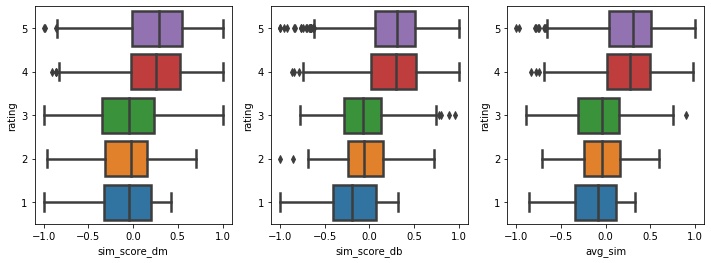

In [30]:
def make_val_boxplots(val):
    
    fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(12,4))
    a = sns.boxplot(x='sim_score_dm',y='rating',
                        dodge=False,linewidth=2.5,orient='h',data=val,ax = axes[0])
    a.invert_yaxis()
    b = sns.boxplot(x='sim_score_db',y='rating',
                        dodge=False,linewidth=2.5,orient='h',data=val,ax = axes[1])
    b.invert_yaxis()
    c = sns.boxplot(x='avg_sim',y='rating',
                        dodge=False,linewidth=2.5,orient='h',data=val,ax = axes[2])
    c.invert_yaxis()
    
make_val_boxplots(val)

## Experimenting with another plot format

In [35]:
def into_ranked_dataframe(sim):
    """ Takes the output of doc2vec most_similar and puts it into
    a dataframe thats nice to work with """
    tmp = pd.DataFrame(sim,columns = ['product_label','sim_score'])
    tmp['rank'] = tmp.index
    tmp['name'] = tmp['product_label'].apply(lambda r: label_decoder[r])
    
    return tmp[['name','rank']].set_index('name')

def generate_rankings_data(user):
    num_returned = 1000
    userdata = df[df['review_author']==user]
    
    if len(userdata.groupby('rating').count()) == 1:
        return

    
    low_rankings = userdata[userdata['rating'] <= 3].sort_values(by='rating',ascending=True)
    high_rankings = userdata[userdata['rating'] >= 4].sort_values(by='rating',ascending=False)
    
#     if len(low_rankings) < 3:
#         return
    
    negatives = [val for val in low_rankings.head(2)['product_label']]
    positives = [val for val in high_rankings.head(2)['product_label']]
    
    
    similar_items_dbow = model_dbow.docvecs.most_similar(positive=positives,negative = negatives,topn=num_returned)
    similar_items_dm = model_dm.docvecs.most_similar(positive=positives,negative = negatives,topn=num_returned)
    
    db_frame = into_ranked_dataframe(similar_items_dbow)
    dm_frame = into_ranked_dataframe(similar_items_dm)

    joined = db_frame.join(dm_frame,lsuffix='_db',rsuffix='_dm')
    joined['avg_rank'] = joined.mean(axis=1)

    tmp = userdata[['product','rating']].set_index('product')
    val = tmp.join(joined,how='left')
    val.dropna(how='any',axis=0,inplace=True)
    
#     val[['rank_db','rank_dm','avg_rank']] = val[['rank_db','rank_dm','avg_rank']]/val[['rank_db','rank_dm','avg_rank']].max(axis=0)
    
    return val

In [36]:
val = pd.concat([generate_rankings_data(user) for user in authorgroup.index],axis=0)

In [37]:
val.head()

,rating,rank_db,rank_dm,avg_rank
Blue Buffalo Healthy Gourmet Pate Turkey & Chicken Entree Adult Canned Cat Food,4,7.0,12.0,9.5
Nutro Max Adult Lamb & Turkey Cutlets Entree Chunks in Sauce Canned Cat Food,5,201.0,290.0,245.5
Ziwi Peak Mackerel & Lamb Recipe Canned Cat Food,5,62.0,69.0,65.5
Tiny Tiger Pate Salmon Recipe Grain-Free Canned Cat Food,3,365.0,342.0,353.5
Wellness CORE Natural Grain Free Turkey & Duck Pate Canned Cat Food,4,272.0,413.0,342.5


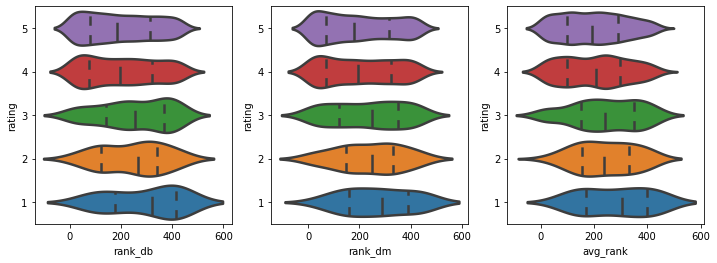

In [38]:
fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(12,4))


a = sns.violinplot(x='rank_db',y='rating',inner='quartiles',
                    dodge=False,linewidth=2.5,orient='h',data=val,ax = axes[0])
a.invert_yaxis()

b = sns.violinplot(x='rank_dm',y='rating',inner='quartiles',
                    dodge=False,linewidth=2.5,orient='h',data=val,ax = axes[1])
b.invert_yaxis()

c = sns.violinplot(x='avg_rank',y='rating',inner='quartiles',
                    dodge=False,linewidth=2.5,orient='h',data=val,ax = axes[2])
c.invert_yaxis()

In [380]:
tmp = generate_rankings_data(user)

In [386]:
tmp[['rank_db','rank_dm','avg_rank']] = tmp[['rank_db','rank_dm','avg_rank']]/tmp[['rank_db','rank_dm','avg_rank']].max(axis=0)

In [387]:
tmp

,rating,rank_db,rank_dm,avg_rank
product,,,,
"Tiki Cat Tahitian Grill Sardine Cutlets Grain-Free Canned Cat Food, 2.8-oz, case of 12",4,0.695988,0.820783,0.762050
"Wellness Complete Health Chicken & Lobster Formula Canned Cat Food, 12.5-oz, case of 12",5,0.385802,0.262048,0.324407
"Weruva Truluxe Pretty In Pink with Salmon in Gravy Grain-Free Canned Cat Food, 3-oz, case of 24",4,0.407407,0.558735,0.485845
"Purina Beyond Grain-Free Trout & Catfish Pate Recipe Canned Cat Food, 3-oz, case of 12",5,0.762346,0.365964,0.563887
"Blue Buffalo Basics Limited Ingredient Grain-Free Indoor Fish & Potato Entree Adult Canned Cat Food, 3-oz, case of 24",4,0.404321,0.293675,0.349656
"Weruva Nine Liver with Chicken & Chicken Liver in Gravy Grain-Free Canned Cat Food, 5.5-oz, case of 24",3,0.944444,1.000000,0.976282
"Tiki Cat Makaha Grill Mackerel & Sardine in Calamari Consomme Grain-Free Canned Cat Food, 6-oz, case of 8",4,0.166667,0.942771,0.561591
"Blue Buffalo Wilderness Wild Delights Flaked Chicken & Turkey Grain-Free Canned Cat Food, 5.5-oz, case of 24",5,0.020062,0.012048,0.016067
"Weruva Truluxe Mediterranean Harvest with Tuna & Veggies in Gravy Grain-Free Canned Cat Food, 3-oz, case of 24",3,1.000000,0.992470,1.000000


In [40]:
mean_product_ratings = df[['product','rating']].groupby('product').mean()

def generate_baseline_for_validation(user):
    num_returned = 1000
    userdata = df[df['review_author']==user]
    
    tmp = userdata[['product','rating']].set_index('product')
    
    val = tmp.join(mean_product_ratings,how='left',rsuffix='_mean')
    
    return val

In [41]:
val = pd.concat([generate_baseline_for_validation(user) for user in authorgroup.index],axis=0)


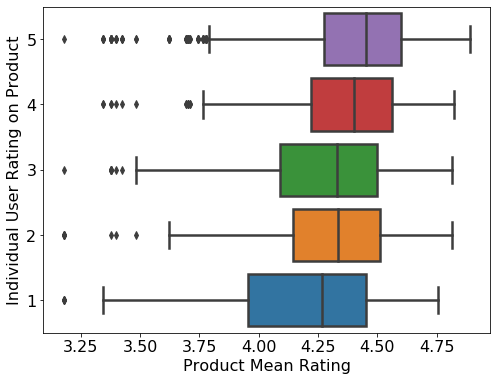

In [56]:
fig = plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size': 16})

a = sns.boxplot(x='rating_mean',y='rating',
                    dodge=False,linewidth=2.5,orient='h',data=val)

plt.xlabel('Product Mean Rating')
plt.ylabel('Individual User Rating on Product')
# plt.title('Baseline for User Decisions')

a.invert_yaxis()

plt.savefig('plots/baseline.png',bbox_inches='tight')

In [65]:
val.head(5)

,rating,sim_score_db,sim_score_dm,avg_sim
product,,,,
Blue Buffalo Healthy Gourmet Pate Turkey & Chicken Entree Adult Canned Cat Food,4,0.727803,0.784648,0.756225
Nutro Max Adult Lamb & Turkey Cutlets Entree Chunks in Sauce Canned Cat Food,5,0.293449,0.205040,0.249244
Ziwi Peak Mackerel & Lamb Recipe Canned Cat Food,5,0.588114,0.542931,0.565522
Tiny Tiger Pate Salmon Recipe Grain-Free Canned Cat Food,3,-0.244665,-0.219459,-0.232062
Wellness CORE Natural Grain Free Turkey & Duck Pate Canned Cat Food,4,0.192075,-0.273811,-0.040868


## Experimenting with quantitative validation

## MAP@K (not complete)

In [16]:
# import pickle
# import numpy as np
# import pandas as pd
# from sklearn.metrics import recall_score, precision_score

# model_dbow = Doc2Vec.load('catfood-d2v-dbow.model')
# model_dm = Doc2Vec.load('catfood-d2v-dm.model')
# label_encoder = pickle.load( open('label-encoder.pkl','rb') )
# label_decoder = pickle.load( open('label-decoder.pkl','rb') )

In [3]:
# df = pd.read_csv('prepared_data.csv')

In [34]:
def binarize(arr, tol):
    """
    Convert continous valued array to binary. 
    """
    arr[arr < tol] = 0
    arr[arr >= tol] = 1
    return arr



def precision_at_k(true, pred, user_ids, k, tol=4.):
    unique_users = np.unique(user_ids.index)
    pred_binarized = binarize(pred.copy(), tol)
    precisions = np.zeros(unique_users.size)
    for i in range(unique_users.size):
        user_ind = user_ids == unique_users[i]
        user_true = true[user_ind]
        user_pred = pred[user_ind]
        user_pred_binarized = pred_binarized[user_ind]
        ranked_ind = np.argsort(-user_pred)[:k]
        precisions[i] = precision_score(user_true[ranked_ind], user_pred_binarized[ranked_ind])
    return precisions
 
def MAP_at_k(true, pred, user_ids, k, tol=3.):
    unique_users = np.unique(user_ids)
    precisions_at_ks = np.zeros((k, unique_users.size))
    for i in range(k):
        precisions_at_ks[i] = precision_at_k(true, pred, user_ids, i+1, tol)
    return np.mean(precisions_at_ks[precisions_at_ks > 0])

In [35]:
author_count = df.groupby('review_author')['review_author'].count()
authorgroup = author_count[(author_count > 5) & (author_count < 20)]
print(len(authorgroup))

621


In [37]:
v = generate_rankings_data('wendyannajones')
